<a href="https://colab.research.google.com/github/DaramGC/AIGS538-Deep-Learning-Final-Project/blob/main/DL_project_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.utils.data as data_utils

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim

In [ ]:
class Preprocess():
  def __init__(self, train_data, test_data):
    self.train_data = train_data
    self.test_data = test_data

    self.features = train_data.columns
    self.in_features = [col for col in train_data.columns if train_data[col].dtype == float and col not in ('median_house_value')]
    self.out_features = ['median_house_value']

    mean, std = self.get_features_mean_std(train_data)
    self.mean = mean
    self.std = std

  def get_features_mean_std(self, data):
    return data[self.features].mean(), data[self.features].std()

  def get_train_input_output(self):
    normalized = (self.train_data[self.features]-self.mean)/self.std
    input = torch.Tensor(normalized[self.in_features].values)
    output = torch.Tensor(normalized[self.out_features].values)
    return [input, output]

  def get_test_input_output(self):
    normalized = (self.test_data[self.features]-self.mean)/self.std
    input = torch.Tensor(normalized[self.in_features].values)
    output = torch.Tensor(normalized[self.out_features].values)
    return input, output

# get data
train_data = pd.read_csv('./sample_data/california_housing_train.csv')
test_data = pd.read_csv('./sample_data/california_housing_test.csv')

preprocessor = Preprocess(train_data=train_data, test_data=test_data)
train_dataset = preprocessor.get_train_input_output()
test_dataset = preprocessor.get_train_input_output()

train_dataset = data_utils.TensorDataset(train_dataset[0], train_dataset[1])
test_dataset = data_utils.TensorDataset(test_dataset[0], test_dataset[1])

# get dataloader
batch_size = 256
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [ ]:
class MLP(nn.Module):
  def __init__(self, regularizer_type: str, train_loader, test_loader, _lambda=1e-4):
    super().__init__()

    if regularizer_type == 'l1':
      self._lambda = _lambda
      self.norm = 1

    if regularizer_type == 'l2':
      self._lambda = _lambda
      self.norm = 2

    if regularizer_type == 'l3':
      self._lambda = _lambda
      self.norm = 3

    self.train_loader = train_loader
    self.test_loader = test_loader

    self.mlp = nn.Sequential(
      nn.Linear(8, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, 1)
    )

    self.loss = nn.MSELoss()
    self.optimizer = optim.Adam(self.mlp.parameters(), lr=0.01)

  def forward(self, x):
    output = self.mlp(x)
    return output

  def get_weight(self):
    return self.mlp[0].weight

  def get_loss(self, output, label):
    first_layer_weight = self.get_weight()
    loss = self.loss(output, label) + self._lambda * torch.norm(first_layer_weight, self.norm)
    return loss

  def train(self, epochs, save):
    self.test_error_list=[]
    self.train_error_list=[]

    self.mlp.train()
    for epoch in tqdm(range(epochs)):
      train_error = 0
      for x, gt in self.train_loader:
        self.optimizer.zero_grad()
        outputs = self(x)

        # train error
        train_error += torch.abs(gt-outputs).sum()

        loss = self.get_loss(outputs, gt)
        loss.backward()
        self.optimizer.step()

      if (epoch+1)%save == 0 or epoch == 0:
        self.show_weight_map(epoch)

      error = float(train_error/len(self.train_loader))
      self.train_error_list.append(str(error))
      if (epoch+1)%50 == 0 or epoch == 0:
        print(f'\nTrain Error : {error}')
      self.test(epoch)

    # save error
    with open(f'./L{self.norm}_test_error.txt', 'w') as f1:
      f1.write('\n'.join(self.test_error_list))
    with open(f'./L{self.norm}_train_error.txt', 'w') as f2:
      f2.write('\n'.join(self.train_error_list))

  def test(self, epoch):
      error=0
      self.mlp.eval()
      with torch.no_grad():
        for x, gt in self.test_loader:
          outputs = self(x)
          error += torch.abs(gt-outputs).sum()

      error = float(error/len(self.test_loader))
      self.test_error_list.append(str(error))
      if (epoch+1)%50 == 0 or epoch == 0:
        print(f'Test Error : {error}')
      self.mlp.train()

  def show_weight_map(self, epoch):
    w = self.get_weight()
    w = torch.mean(w, dim=0)
    # print(f'\n MAX : {w.max()}, MIN : {w.min()}')
    norm_w = torch.abs(w/torch.abs(w).max())
    image = np.repeat(norm_w.view(1,8,1).detach().numpy(),3,-1)

    # upscale image
    scale = 50
    new_image = np.zeros((image.shape[0]*scale, image.shape[1]*scale, image.shape[2]))

    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        new_image[i*scale:(i+1)*scale, j*scale:(j+1)*scale] = image[i,j]

    plt.axis('off')
    plt.imsave(f'L{self.norm}_weight_{epoch}.png', new_image, cmap='gray')
    plt.imshow(image, cmap='gray')

  0%|          | 0/1000 [00:00<?, ?it/s]


Train Error : 109.32527923583984


  0%|          | 1/1000 [00:00<16:08,  1.03it/s]


Test Error : 96.25692749023438


  5%|▍         | 49/1000 [00:24<07:48,  2.03it/s]


Train Error : 72.51262664794922


  5%|▌         | 50/1000 [00:25<08:43,  1.81it/s]


Test Error : 70.86425018310547


 10%|█         | 100/1000 [00:50<07:04,  2.12it/s]


Train Error : 69.2649917602539

Test Error : 70.52572631835938


 15%|█▍        | 149/1000 [01:16<09:49,  1.44it/s]


Train Error : 66.34158325195312


 15%|█▌        | 150/1000 [01:18<13:46,  1.03it/s]


Test Error : 65.649169921875


 20%|█▉        | 199/1000 [01:45<08:12,  1.63it/s]


Train Error : 65.4692611694336


 20%|██        | 200/1000 [01:45<08:37,  1.55it/s]


Test Error : 63.71842956542969


 25%|██▍       | 249/1000 [02:10<07:04,  1.77it/s]


Train Error : 63.77518844604492


 25%|██▌       | 250/1000 [02:11<08:27,  1.48it/s]


Test Error : 62.24776840209961


 30%|██▉       | 299/1000 [02:35<06:48,  1.72it/s]


Train Error : 62.58526611328125


 30%|███       | 300/1000 [02:36<07:10,  1.62it/s]


Test Error : 60.48884582519531


 35%|███▍      | 349/1000 [03:02<06:37,  1.64it/s]


Train Error : 62.310890197753906


 35%|███▌      | 350/1000 [03:03<07:07,  1.52it/s]


Test Error : 62.0852165222168


 40%|████      | 400/1000 [03:30<06:21,  1.57it/s]


Train Error : 61.07650375366211

Test Error : 60.96012496948242


 45%|████▌     | 450/1000 [03:56<05:50,  1.57it/s]


Train Error : 61.985862731933594

Test Error : 59.88138961791992


 50%|█████     | 500/1000 [04:22<05:02,  1.66it/s]


Train Error : 60.720027923583984

Test Error : 58.18364334106445


 55%|█████▌    | 550/1000 [04:48<04:37,  1.62it/s]


Train Error : 60.946380615234375

Test Error : 58.829444885253906


 60%|██████    | 600/1000 [05:14<04:11,  1.59it/s]


Train Error : 60.78451156616211

Test Error : 60.43867111206055


 65%|██████▌   | 650/1000 [05:42<02:58,  1.96it/s]


Train Error : 59.296321868896484

Test Error : 58.16537094116211


 70%|███████   | 700/1000 [06:08<02:27,  2.04it/s]


Train Error : 59.83710861206055

Test Error : 59.74671173095703


 75%|███████▌  | 750/1000 [06:34<02:09,  1.93it/s]


Train Error : 59.12556838989258

Test Error : 58.66233444213867


 80%|████████  | 800/1000 [07:01<01:42,  1.95it/s]


Train Error : 60.083251953125

Test Error : 59.42963409423828


 85%|████████▌ | 850/1000 [07:29<01:55,  1.30it/s]


Train Error : 59.21279525756836

Test Error : 57.45877456665039


 90%|█████████ | 900/1000 [07:58<00:49,  2.04it/s]


Train Error : 58.26102828979492

Test Error : 57.60963439941406


 95%|█████████▌| 950/1000 [08:25<00:24,  2.07it/s]


Train Error : 59.58782196044922

Test Error : 57.414615631103516


100%|██████████| 1000/1000 [08:51<00:00,  1.88it/s]


Train Error : 58.98606872558594

Test Error : 58.705448150634766


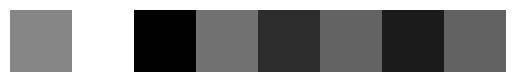

In [ ]:
# define model
model_l1 = MLP(regularizer_type='l1', train_loader=train_loader, test_loader=test_loader)
# train
model_l1.train(epochs=1000, save=100)

  0%|          | 1/1000 [00:00<10:40,  1.56it/s]


Train Error : 106.78397369384766

Test Error : 95.95207977294922


  5%|▍         | 49/1000 [00:24<09:57,  1.59it/s]


Train Error : 72.11425018310547


  5%|▌         | 50/1000 [00:25<10:27,  1.51it/s]


Test Error : 72.98638153076172


 10%|▉         | 99/1000 [00:49<08:28,  1.77it/s]


Train Error : 66.80867767333984


 10%|█         | 100/1000 [00:50<09:01,  1.66it/s]


Test Error : 65.39752960205078


 15%|█▍        | 149/1000 [01:15<06:56,  2.05it/s]


Train Error : 64.28805541992188


 15%|█▌        | 150/1000 [01:15<07:47,  1.82it/s]


Test Error : 60.51660919189453


 16%|█▋        | 164/1000 [01:23<07:05,  1.96it/s]


KeyboardInterrupt: 

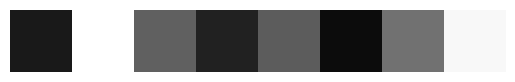

In [ ]:
# define model
model_l2 = MLP(regularizer_type='l2', train_loader=train_loader, test_loader=test_loader)
# train
model_l2.train(epochs=1000, save=100)

In [ ]:
# define model
model_l3 = MLP(regularizer_type='l3', train_loader=train_loader, test_loader=test_loader)
# train
model_l3.train(epochs=1000, save=100)